In [1]:
!nvidia-smi


Mon May 24 04:50:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

In [3]:
print('Tesnsorflow version', tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Tesnsorflow version 2.4.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 76634469921313224
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15685569792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2353415139117390867
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
train_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/train'
test_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/valid'

In [5]:
label = [w[9:] for w in os.listdir(train_path)]
disease_list=  os.listdir(train_path)

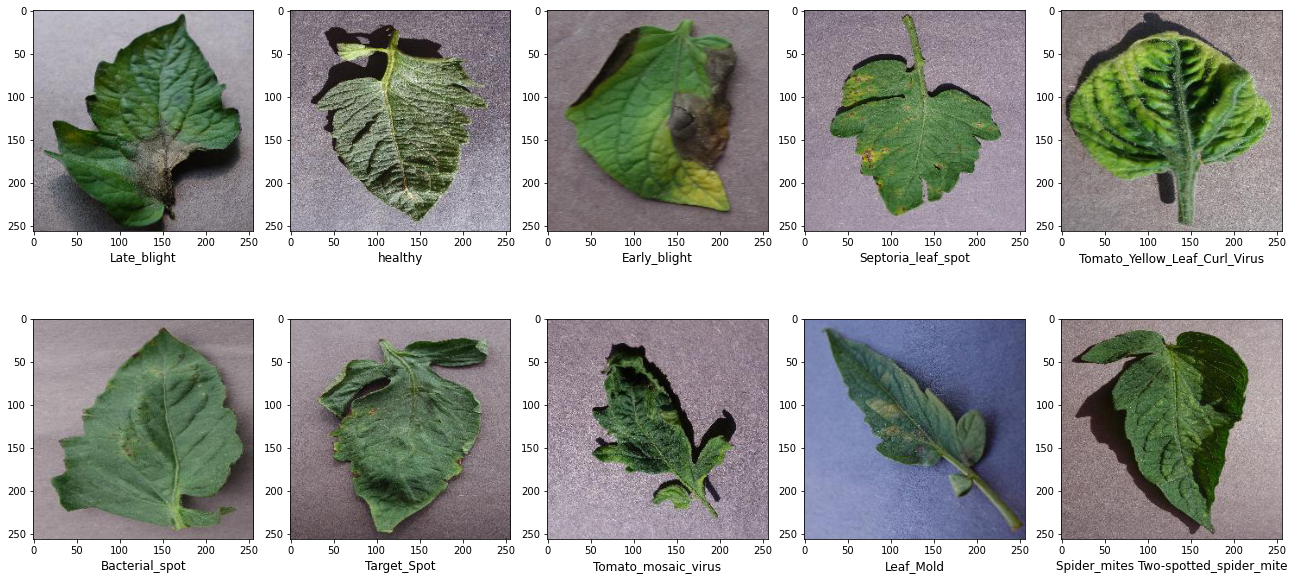

In [6]:
from tensorflow.keras.preprocessing.image import load_img
fig = plt.figure(figsize=(11,6))
fig.set_size_inches(18,9)
#plt.style.use("ggplot")
i = 0
leaf = []
disease_name = []
leaf_img = []

for disease in disease_list:
    sample = random.sample(os.listdir(train_path+"/"+disease),1)
    leaf.append(sample)
    disease_name.append(disease)
    
for image in leaf:
    leaf_img.append(image[0]) 
    
i=0    
for image in leaf_img:
    img = load_img(train_path+"/"+disease_name[i]+"/"+image)
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.xlabel(disease_name[i][9:], fontsize=12)
    #plt.yticks([])
    i+=1
plt.tight_layout()


In [7]:
IMAGE_SIZE = [224, 224]


In [8]:
# number of output classes
len(glob(train_path+'/*')), len(glob(test_path+'/*'))



(10, 10)

In [9]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
# reading from directory 
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [11]:
from collections import Counter

counter = Counter(train_set.classes)
print(counter.items())

# Target class labels
labels = dict((y,x) for x,y in train_set.class_indices.items())
labels



dict_items([(0, 1702), (1, 1920), (2, 1851), (3, 1882), (4, 1745), (5, 1741), (6, 1827), (7, 1961), (8, 1790), (9, 1926)])


{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spotted_spider_mite',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

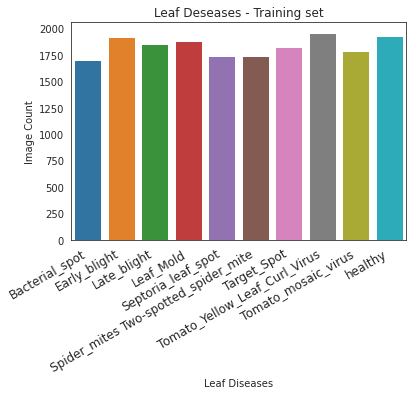

In [12]:
res2 = {}
for k, v in labels.items():
    res2[v] = counter[k]
    
sns.set_style("white")
my_df =  pd.DataFrame(res2.items())
my_df.iloc[:,0] =  my_df.iloc[:,0].apply(lambda x: x[9:])
plt.rcParams['figure.figsize']=(6,4)
ax = sns.barplot(x=0, y=1, data=my_df,)
ax.set_title('Leaf Deseases - Training set')
ax.set_xlabel("Leaf Diseases")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize= 12)
ax.set_ylabel("Image Count")
plt.savefig('foo.png', bbox_inches="tight")

In [13]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


87916544/87910968 [==============================] - 1s 0us/step


In [14]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [15]:
# our layers - you can add more if you want
x = Flatten()(inception.output)
x

<KerasTensor: shape=(None, 51200) dtype=float32 (created by layer 'flatten')>

In [16]:
prediction = Dense(10, activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [17]:
#model.summary()
len(train_set)
len(train_set)


287

In [18]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=8,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set)
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
287/287 [==============================] - 280s 950ms/step - loss: 4.6612 - accuracy: 0.5742 - val_loss: 1.5734 - val_accuracy: 0.7361
Epoch 2/8
287/287 [==============================] - 219s 764ms/step - loss: 1.2360 - accuracy: 0.7932 - val_loss: 1.1066 - val_accuracy: 0.8308
Epoch 3/8
287/287 [==============================] - 219s 763ms/step - loss: 1.0808 - accuracy: 0.8358 - val_loss: 1.2226 - val_accuracy: 0.8275
Epoch 4/8
287/287 [==============================] - 218s 759ms/step - loss: 1.2016 - accuracy: 0.8367 - val_loss: 1.5325 - val_accuracy: 0.8111
Epoch 5/8
287/287 [==============================] - 217s 754ms/step - loss: 1.0641 - accuracy: 0.8647 - val_loss: 1.8637 - val_accuracy: 0.8068
Epoch 6/8
287/287 [==============================] - 218s 761ms/step - loss: 1.0562 - accuracy: 0.8687 - val_loss: 1.2559 - val_accuracy: 0.8580
Epoch 7/8
287/287 [==============================] - 217s 755ms/step - loss: 1.0801 - accuracy: 0.8714 - val_loss: 1.3773 - val_ac

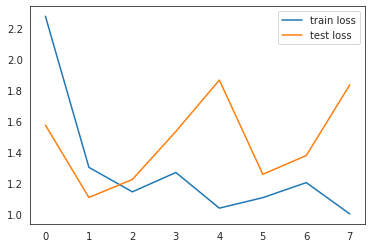

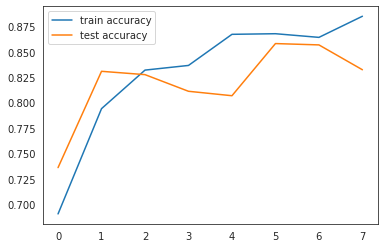

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Loss over Epochs')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy over Epochs')

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


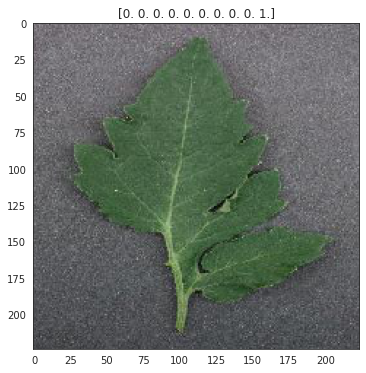

In [20]:
data, label = test_set.next()

plt.figure(figsize=(6, 6))
plt.imshow(data[1])
plt.title(label[1])
plt.show()

In [21]:
data.shape, label.shape


((64, 224, 224, 3), (64, 10))

In [22]:
x= data[1]
x= x/255

x=np.expand_dims(x,axis=0)
x=preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [23]:
#model.predict(x)
np.argmax(model.predict(x), axis=1)


array([2])

In [24]:
model.save('model_inception_.h5')